In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

In [2]:
# Reproducibility
common.set_seed(1)

In [3]:
# for GPU
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1  
transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
])
outputs = 100     # for cifar100, output classes = 10
inputs = 3       # for cifar100, color channels = 3
modelname = 'alexnet-cifar100.pt'

In [5]:
trainset = torchvision.datasets.CIFAR100(root='.', train=True, download=True, transform=transform_cifar100)
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

Files already downloaded and verified


In [6]:
class BBBAlexNet(common.ModuleWrapper):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBAlexNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = common.layers.BBB_LRT_Linear
            BBBConv2d = common.layers.BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = common.layers.BBB_Linear
            BBBConv2d = common.layers.BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 64, 11, stride=4, padding=5, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(64, 192, 5, padding=2, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(192, 384, 3, padding=1, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.conv4 = BBBConv2d(384, 256, 3, padding=1, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.conv5 = BBBConv2d(256, 128, 3, padding=1, bias=True, priors=self.priors)
        self.act5 = self.act()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = common.layers.FlattenLayer(1 * 1 * 128)
        self.classifier = BBBLinear(1 * 1 * 128, outputs, bias=True, priors=self.priors)

In [7]:
# follows the procedure for sampling in the forward methods of BBBConv and 
# BBBLinear forward to create a fixed set of weights to use for the sampled model
def sample_conv2d(bbb_layer):
    conv_W_mu = bbb_layer.W_mu
    conv_W_rho = bbb_layer.W_rho
    conv_W_eps = torch.empty(conv_W_mu.size()).normal_(0,1).to(device)
    conv_W_sigma = torch.log1p(torch.exp(conv_W_rho))
    conv_weight = conv_W_mu + conv_W_eps * conv_W_sigma
    if bbb_layer.use_bias:
        conv_bias_mu = bbb_layer.bias_mu
        conv_bias_rho = bbb_layer.bias_rho
        conv_bias_eps = torch.empty(conv_bias_mu.size()).normal_(0,1).to(device)
        conv_bias_sigma = torch.log1p(torch.exp(conv_bias_rho))
        conv_bias = conv_bias_mu + conv_bias_eps * conv_bias_sigma
    else:
        conv_bias = None
    return conv_weight.data, conv_bias.data

def sample_linear(bbb_layer):
        fc_W_mu = bbb_layer.W_mu
        fc_W_rho = bbb_layer.W_rho
        fc_W_eps = torch.empty(fc_W_mu.size()).normal_(0,1).to(device)
        fc_W_sigma = torch.log1p(torch.exp(fc_W_rho))
        fc_weight = fc_W_mu + fc_W_eps * fc_W_sigma
        if bbb_layer.use_bias:
            fc_bias_mu = bbb_layer.bias_mu
            fc_bias_rho = bbb_layer.bias_rho
            fc_bias_eps = torch.empty(fc_bias_mu.size()).normal_(0,1).to(device)
            fc_bias_sigma = torch.log1p(torch.exp(fc_bias_rho))
            fc_bias = fc_bias_mu + fc_bias_eps * fc_bias_sigma
        else:
            fc_bias = None
        
        return fc_weight.data, fc_bias.data

class AlexNet(nn.Module):
    
    def __init__(self, outputs, inputs, layer_type='lrt', activation_type='softplus'):
        '''
        Base AlexNet model that matches the architecture of BayesianAlexNet with randomly 
        initialized weights
        '''
        super(AlexNet, self).__init__()
        
        # initialization follows the BBBAlexNet initialization, changing
        # BBBLinear and BBBConv2D layers to nn.Linear and nn.Conv2D
        
        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = nn.Conv2d(inputs, 64, 11, stride=4, padding=5, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 192, 5, padding=2, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(192,384,3, padding=1, bias=True)
        self.act3 = self.act()

        self.conv4 = nn.Conv2d(384,256,3, padding=1, bias=True)
        self.act4 = self.act()
        
        self.conv5 = nn.Conv2d(256, 128, 3, padding=1, bias=True)
        self.act5 = self.act()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # call x.view explicitly in forward
        self.classifier = nn.Linear(1 * 1 * 128, outputs, bias=True)

    def sample(self, bbbnet):
        ### store activation function used by BNN, only relu and softplus  currently supported
        self.act1 = bbbnet.act()
        self.act2 = bbbnet.act()
        self.act3 = bbbnet.act()
        self.act4 = bbbnet.act()

        ### maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=bbbnet.pool1.kernel_size, stride=bbbnet.pool1.stride)
        self.pool2 = nn.MaxPool2d(kernel_size=bbbnet.pool2.kernel_size, stride=bbbnet.pool2.stride)
        self.pool3 = nn.MaxPool2d(kernel_size=bbbnet.pool3.kernel_size, stride=bbbnet.pool3.stride)

        ### Create Convolution layers
        self.conv1 = nn.Conv2d(bbbnet.conv1.in_channels, bbbnet.conv1.out_channels, bbbnet.conv1.kernel_size,
                                stride=bbbnet.conv1.stride, padding=bbbnet.conv1.padding, dilation=bbbnet.conv1.dilation,
                                groups=bbbnet.conv1.groups)
        
        self.conv2 = nn.Conv2d(bbbnet.conv2.in_channels, bbbnet.conv2.out_channels, bbbnet.conv2.kernel_size,
                        stride=bbbnet.conv2.stride, padding=bbbnet.conv2.padding, dilation=bbbnet.conv2.dilation,
                        groups=bbbnet.conv2.groups)

        self.conv3 = nn.Conv2d(bbbnet.conv3.in_channels, bbbnet.conv3.out_channels, bbbnet.conv3.kernel_size,
                                stride=bbbnet.conv3.stride, padding=bbbnet.conv3.padding, dilation=bbbnet.conv3.dilation,
                                groups=bbbnet.conv3.groups)
        
        self.conv4 = nn.Conv2d(bbbnet.conv4.in_channels, bbbnet.conv4.out_channels, bbbnet.conv4.kernel_size,
                        stride=bbbnet.conv4.stride, padding=bbbnet.conv4.padding, dilation=bbbnet.conv4.dilation,
                        groups=bbbnet.conv4.groups)

        self.conv5 = nn.Conv2d(bbbnet.conv5.in_channels, bbbnet.conv5.out_channels, bbbnet.conv5.kernel_size,
                        stride=bbbnet.conv5.stride, padding=bbbnet.conv5.padding, dilation=bbbnet.conv5.dilation,
                        groups=bbbnet.conv5.groups)

        # Sample convolutional layers
        self.conv1.weight.data, self.conv1.bias.data = sample_conv2d(bbbnet.conv1)
        self.conv2.weight.data, self.conv2.bias.data = sample_conv2d(bbbnet.conv2)
        self.conv3.weight.data, self.conv3.bias.data = sample_conv2d(bbbnet.conv3)
        self.conv4.weight.data, self.conv4.bias.data = sample_conv2d(bbbnet.conv4)
        self.conv5.weight.data, self.conv5.bias.data = sample_conv2d(bbbnet.conv5)

        ### Create Linear Layers
        self.classifier = nn.Linear(bbbnet.classifier.in_features, bbbnet.classifier.out_features, bbbnet.classifier.use_bias)
        self.classifier.weight.data, self.classifier.bias.data = sample_linear(bbbnet.classifier)            

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        x = self.conv4(x)
        x = self.act4(x)

        x = self.conv5(x)
        x = self.act5(x)
        x = self.pool3(x)

        x = x.view(-1, 1 * 1 * 128)
        x = self.classifier(x)
        return x

In [8]:
net = BBBAlexNet(outputs, inputs, priors, layer_type, activation_type).to(device)

In [9]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = AlexNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [10]:
def load_models(modelname, K = 100):
    # Load the models
    sampled_models = [AlexNet(outputs, inputs, layer_type, activation_type) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load(modelname)):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [11]:
train_and_save_models(epochs = 200, K = 100, modelname = modelname)
sampled_models = load_models(modelname, K = 100)

Epoch:0, TrainLoss:37070614.306, TrainAcc:0.020, ValLoss:28249598.950, ValAcc:0.027, KL:365088772.280
Epoch:1, TrainLoss:23648562.904, TrainAcc:0.034, ValLoss:19910546.000, ValAcc:0.042, KL:234236578.752
Epoch:2, TrainLoss:17356923.809, TrainAcc:0.052, ValLoss:15144468.975, ValAcc:0.057, KL:171402256.204
Epoch:3, TrainLoss:13491576.121, TrainAcc:0.063, ValLoss:12017108.250, ValAcc:0.067, KL:132830326.522
Epoch:4, TrainLoss:10859257.350, TrainAcc:0.074, ValLoss:9806308.150, ValAcc:0.077, KL:106547534.166
Epoch:5, TrainLoss:8955101.927, TrainAcc:0.078, ValLoss:8170029.062, ValAcc:0.081, KL:87530780.688
Epoch:6, TrainLoss:7519434.293, TrainAcc:0.084, ValLoss:6915087.725, ValAcc:0.085, KL:73194027.618
Epoch:7, TrainLoss:6403313.487, TrainAcc:0.086, ValLoss:5924436.763, ValAcc:0.092, KL:62049268.306
Epoch:8, TrainLoss:5514202.051, TrainAcc:0.093, ValLoss:5127934.125, ValAcc:0.096, KL:53176913.274
Epoch:9, TrainLoss:4793116.105, TrainAcc:0.095, ValLoss:4476531.237, ValAcc:0.096, KL:45976573.

Epoch:85, TrainLoss:168079.314, TrainAcc:0.250, ValLoss:178136.606, ValAcc:0.229, KL:177176.504
Epoch:86, TrainLoss:167766.031, TrainAcc:0.250, ValLoss:178587.654, ValAcc:0.224, KL:178121.440
Epoch:87, TrainLoss:167372.234, TrainAcc:0.252, ValLoss:180207.266, ValAcc:0.216, KL:178719.429
Epoch:88, TrainLoss:167135.991, TrainAcc:0.254, ValLoss:178700.074, ValAcc:0.230, KL:179785.139
Epoch:89, TrainLoss:167092.294, TrainAcc:0.253, ValLoss:178264.515, ValAcc:0.228, KL:180621.681
Epoch:90, TrainLoss:166692.180, TrainAcc:0.254, ValLoss:177921.652, ValAcc:0.228, KL:181643.610
Epoch:91, TrainLoss:166515.054, TrainAcc:0.256, ValLoss:178384.919, ValAcc:0.228, KL:182348.682
Epoch:92, TrainLoss:165905.827, TrainAcc:0.259, ValLoss:179176.505, ValAcc:0.224, KL:183224.746
Epoch:93, TrainLoss:166063.873, TrainAcc:0.260, ValLoss:178450.118, ValAcc:0.227, KL:184431.957
Epoch:94, TrainLoss:166023.693, TrainAcc:0.262, ValLoss:177464.347, ValAcc:0.232, KL:185195.342
Epoch:95, TrainLoss:165755.470, TrainAcc

Epoch:167, TrainLoss:158973.048, TrainAcc:0.287, ValLoss:176609.341, ValAcc:0.241, KL:190087.188
Epoch:168, TrainLoss:159411.715, TrainAcc:0.286, ValLoss:177892.668, ValAcc:0.236, KL:190087.138
Epoch:169, TrainLoss:159580.539, TrainAcc:0.286, ValLoss:176440.416, ValAcc:0.242, KL:190087.118
Epoch:170, TrainLoss:159631.456, TrainAcc:0.285, ValLoss:176369.316, ValAcc:0.244, KL:190087.109
Epoch:171, TrainLoss:159424.497, TrainAcc:0.284, ValLoss:177797.868, ValAcc:0.237, KL:190087.073
Epoch:172, TrainLoss:159429.712, TrainAcc:0.287, ValLoss:176248.566, ValAcc:0.245, KL:190087.050
Epoch:173, TrainLoss:159114.578, TrainAcc:0.288, ValLoss:177414.308, ValAcc:0.239, KL:190087.027
Epoch:174, TrainLoss:159140.350, TrainAcc:0.289, ValLoss:177424.152, ValAcc:0.243, KL:190087.002
Epoch:175, TrainLoss:159764.271, TrainAcc:0.284, ValLoss:176792.519, ValAcc:0.242, KL:190086.980
Epoch:176, TrainLoss:158876.278, TrainAcc:0.288, ValLoss:176188.513, ValAcc:0.244, KL:190086.951
Epoch:177, TrainLoss:159470.49

In [12]:
testset = torchvision.datasets.CIFAR100(root='.', train=False, download=True, transform=transform_cifar100)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=num_workers)

Files already downloaded and verified


In [13]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))

In [14]:
targets

tensor([49])

In [15]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [16]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone()-eps*saliency, 0, 1)

In [17]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, eps, saliency):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        # One step Target Class Method (OTCM); saliency is noise
        new_images = otcm(images, eps, saliency)
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

In [18]:
# Collect noises (saliencies)
EPS = 0.1
saliencies = []
how_many_fooled = []
torch.set_printoptions(sci_mode=False)
for k in range(len(sampled_models)):
    # Forward pass
    # Compute loss w.r.t. an incorrect class
    # Note that we just have to ensure this class is different from targets
    images.grad = None
    images.requires_grad = True
    old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), torch.tensor([1])])
    # Compute adversarial example
    new_images = otcm(images, EPS, images.grad.sign())
    # Forward pass on adv. example
    new_class = forward_pass(sampled_models[k], new_images)
    if old_class != new_class:
        # How many models can this adv. example fool?
        how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign())]
        saliencies += [images.grad.sign().squeeze()]

In [19]:
# distributional saliency map
saliencies = torch.stack(saliencies)
print(saliencies.shape)
unbatched_shape = saliencies.shape[1:]
print(unbatched_shape)
newsaliency = torch.zeros(unbatched_shape)

for i in range(unbatched_shape[0]):
    for j in range(unbatched_shape[1]):
        for k in range(unbatched_shape[2]):
            # choose median perturbation
            newsaliency[i, j, k] = np.percentile(saliencies[:, i, j, k].numpy(), 50)

torch.Size([100, 3, 32, 32])
torch.Size([3, 32, 32])


In [20]:
print(how_many_can_it_fool(sampled_models, EPS, newsaliency))
new_images = otcm(images, EPS, newsaliency)

0.99


In [21]:
np.mean(how_many_fooled)

0.9451

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<MaxBackward1>)


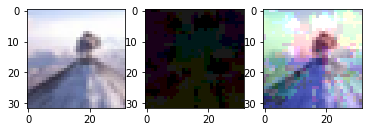

In [22]:
plt.figure()
plt.subplot(1, 3, 1)
images = images.squeeze() # squeeze out batch dimension
image_transpose = np.transpose( images.detach().numpy() , (1,2,0))  
plt.imshow(image_transpose)
plt.subplot(1, 3, 2)
perturbation = newsaliency * EPS
perturbation_transpose = np.transpose(perturbation.detach().numpy(), (1,2,0))
plt.imshow(perturbation_transpose, vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
new_images = new_images.squeeze()
print(torch.max(new_images))
new_images_transpose = np.transpose(new_images.detach().numpy(), (1,2,0))
plt.imshow(new_images_transpose)
plt.show()